In [1]:
%load_ext autoreload
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from torchvision.datasets import MNIST, CIFAR10 
from torch.utils.data import DataLoader, Subset, TensorDataset
from sklearn.model_selection import StratifiedShuffleSplit

%autoreload 2
from networks import *
from utils import *
from losses import *

import matplotlib.pyplot as plt
import progressbar
import random

In [2]:
# Set seed, clear cache and enable anomaly detection (for debugging)
set_seed(42)
torch.cuda.empty_cache()
torch.autograd.set_detect_anomaly(True)


# Set training static parameters and hyperparameters
nepochs=50
dims_latent = 16                            
learning_rate=1e-3
batch_size=32                                        
device=set_device("cuda", 1)
train_transform = Compose([
    Resize(28),
    ToTensor(),
])
train_size=0.005

Cuda installed but only 1 GPU(s) available! Running on GPU 0 GeForce GTX 1650!


# MNIST Example

In [5]:
# Datasets and dataloaders
ds = MNIST("./", download=False, train=True, transform=train_transform)
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=1-train_size, random_state=42).split(ds.data, ds.targets)
train_idx, valid_idx = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

X_train, y_train = ds.data[train_idx] / 255., ds.targets[train_idx]
trainds = TensorDataset(X_train.unsqueeze(1).float(), y_train.float())

idx_5 = []
for i in range(len(ds)):
    if ds[i][1] == 5:
        idx_5.append(i)
        if len(idx_5) == 1:
            break
trainds = Subset(ds, idx_5)

train_loader = DataLoader(trainds, batch_size=batch_size, shuffle=True, num_workers=4)

X = trainds[0][0].unsqueeze(0).to(device) # a sample for check ups
print("Trainable Images:", len(trainds))
print(X.shape, X.min().item(), X.max().item())

Trainable Images: 1
torch.Size([1, 1, 28, 28]) 0.0 1.0


## Autoencoder

torch.Size([1, 1, 28, 28]) torch.Size([1, 1, 28, 28])


Training started ...


N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--


 {'epoch': 0, 'train_mse_loss': 0.24714337289333344, 'train_awi2d_loss': 0.4999823570251465}
 argidx T, v:  1512 1685


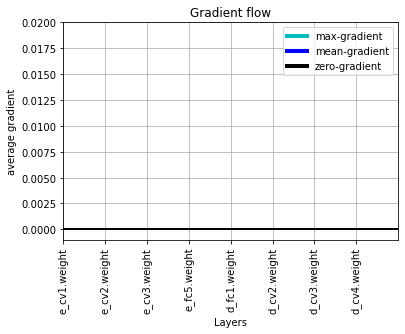

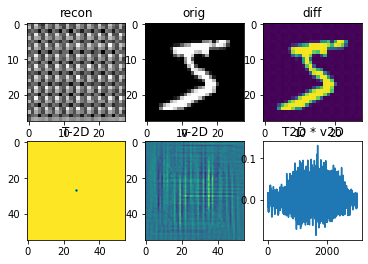

 20% (10 of 50) |####                    | Elapsed Time: 0:01:28 ETA:   0:06:19


 {'epoch': 10, 'train_mse_loss': 0.24635791778564453, 'train_awi2d_loss': 0.49555155634880066}
 argidx T, v:  1512 1512


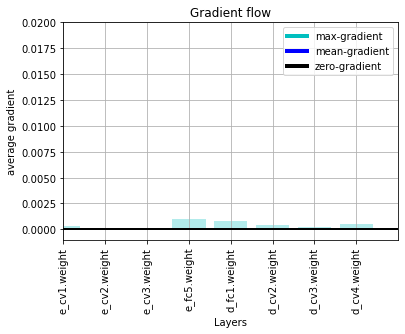

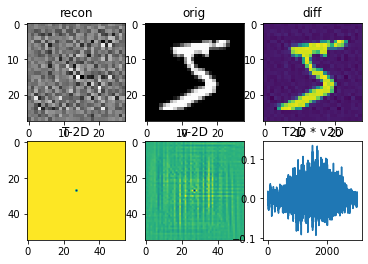

 40% (20 of 50) |#########               | Elapsed Time: 0:03:01 ETA:   0:03:42


 {'epoch': 20, 'train_mse_loss': 0.28338146209716797, 'train_awi2d_loss': 0.40812012553215027}
 argidx T, v:  1512 1512


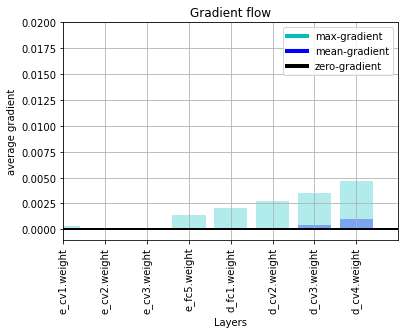

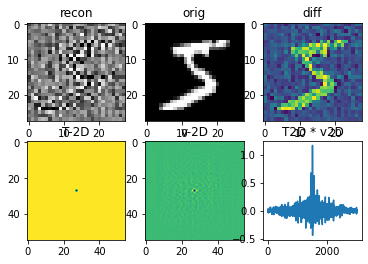

 60% (30 of 50) |##############          | Elapsed Time: 0:04:14 ETA:   0:01:51


 {'epoch': 30, 'train_mse_loss': 0.28730958700180054, 'train_awi2d_loss': 0.34434619545936584}
 argidx T, v:  1512 1512


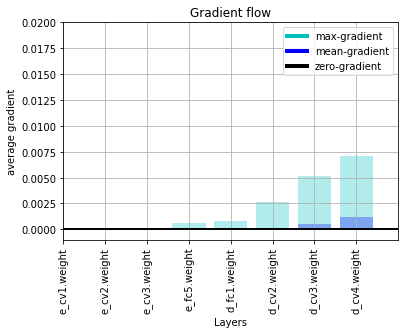

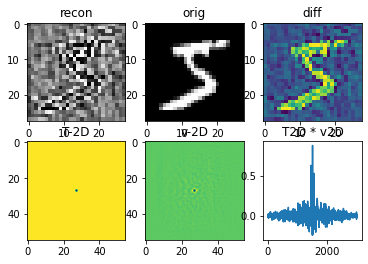

 80% (40 of 50) |###################     | Elapsed Time: 0:05:21 ETA:   0:01:08


 {'epoch': 40, 'train_mse_loss': 0.2804911136627197, 'train_awi2d_loss': 0.2988499104976654}
 argidx T, v:  1512 1512


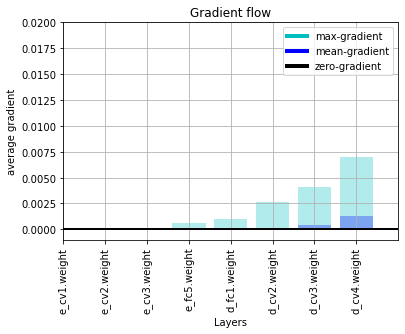

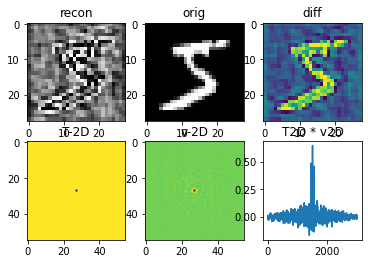

 98% (49 of 50) |####################### | Elapsed Time: 0:06:09 ETA:   0:00:03


 {'epoch': 49, 'train_mse_loss': 0.27153050899505615, 'train_awi2d_loss': 0.26560917496681213}
 argidx T, v:  1512 1512


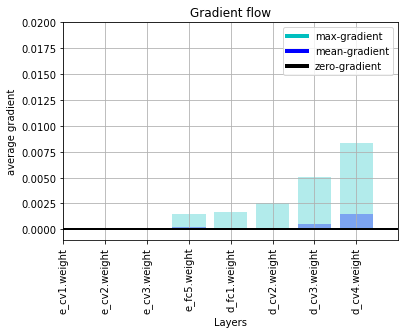

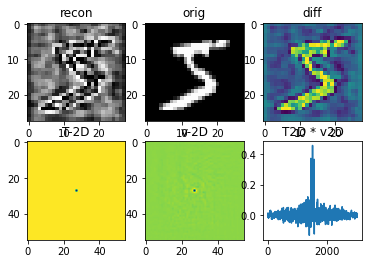

100% (50 of 50) |########################| Elapsed Time: 0:06:10 Time:  0:06:10


In [6]:
# Model and optimisers
model = CAE28(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X).shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi2D     = AWLoss2D(reduction="sum", std=1e-4, return_filters=False)
awi2D_val = AWLoss2D(reduction="sum", std=1e-4, return_filters=True)
switch_at_epoch = 0 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        if epoch < switch_at_epoch:
            epoch_loss = train_ae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss = train_ae(model, train_loader, optimizer, awi2D, device=device)
            
        epoch_mse = validate_ae(model, train_loader, nn.MSELoss(reduction="mean"), device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse_loss":epoch_mse.item(), "train_awi2d_loss": epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon = model(X)
            
            _, v, T = awi2D_val(recon, X)
            v = v[0]

            print("\n", log)
            print(" argidx T, v: ",torch.argmin(T).item(), torch.argmax(torch.abs(v)).item())

            plot_grad_flow(model.named_parameters())

            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            axs[1, 0].imshow(T.detach().cpu().numpy())
            axs[1, 0].set_title("T-2D")

            axs[1, 1].imshow(v.detach().cpu().numpy())
            axs[1, 1].set_title("v-2D")

            axs[1, 2].plot((T.flatten()*v.flatten()).detach().cpu().numpy())
            axs[1, 2].set_title("T2D * v2D")

            plt.show()


## Variational Autoencoder

In [47]:
# Model and optimisers
model = VAE(dims_latent=dims_latent, nc=X.shape[1]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Input / Output test
print(X.shape, model(X)[0].shape)

# Losses
l2loss    = nn.MSELoss(reduction="sum")
awi2D     = AWLoss2D(reduction="sum", std=1e-4, return_filters=False)
awi2D_val = AWLoss2D(reduction="sum", std=1e-4, return_filters=True)
switch_at_epoch = 10 # swtich from pure l2 to total loss, set to 0 to disable, set to nepochs to run purely mse   


# Training loop
print("\n\nTraining started ...")
with progressbar.ProgressBar(max_value=nepochs) as bar:    
    for epoch in range(nepochs):
        if epoch < switch_at_epoch:
            epoch_loss, epoch_mse, epoch_kl = train_vae(model, train_loader, optimizer, l2loss, device=device)
        else:
            epoch_loss, epoch_mse, epoch_kl = train_vae(model, train_loader, optimizer, awi2D, device=device)
        bar.update(epoch)
            

        # Metric logs and plots
        log = {"epoch": epoch, "train_mse_loss":epoch_mse.item(), "train_awi2d_loss": epoch_loss.item()}
        if epoch % 10 == 0 or epoch==nepochs-1:
            idx = random.randint(0, len(trainds))
            idx=-1
            X = trainds[idx][0].unsqueeze(0).to(device)
            recon, _, _ = model(X)
            
            _, v, T = awi2D_val(recon, X)
            v = v[0]

            print("\n", log)
            print(" argidx T, v: ",torch.argmin(T).item(), torch.argmax(torch.abs(v)).item())
            fig, axs = plt.subplots(2,3)
            axs[0, 0].imshow(recon[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 0].set_title("recon")

            axs[0, 1].imshow(X[0, 0].cpu().detach().numpy(), cmap="gray")
            axs[0, 1].set_title("orig")

            axs[0, 2].imshow(X[0, 0].cpu().detach().numpy() - recon[0, 0].cpu().detach().numpy())
            axs[0, 2].set_title("diff")

            axs[1, 0].imshow(T.detach().cpu().numpy())
            axs[1, 0].set_title("T-2D")

            axs[1, 1].imshow(v.detach().cpu().numpy())
            axs[1, 1].set_title("v-2D")

            axs[1, 2].plot((T.flatten()*v.flatten()).detach().cpu().numpy())
            axs[1, 2].set_title("T2D * v2D")

            plt.show()

ValueError: InstanceNorm1d returns 0-filled tensor to 2D tensor.This is because InstanceNorm1d reshapes inputs to(1, N * C, ...) from (N, C,...) and this makesvariances 0.